<a href="https://colab.research.google.com/github/CarlosSotero/NFL_Stats_Players/blob/main/NFL_Moderna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas nescessárias**

In [145]:
import kagglehub
import os
import pandas as pd
import numpy as np
!pip install nfl_data_py
import nfl_data_py as nfl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## **Download dos datasets**

In [146]:
# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
Path to dataset files: /kaggle/input/nfl-stats-1999-2022


In [147]:
# Mostra os arquivos que vieram no caminho do kagglehub
print(os.listdir(path))


['yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_offense.csv', 'weekly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'weekly_player_stats_defense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv']


In [148]:
# Carregar os datasets anuais por jogador (ofensivo e defensivo)
offense_path = path + "/yearly_player_stats_offense.csv"
defense_path = path + "/yearly_player_stats_defense.csv"
df_offense = pd.read_csv(offense_path)
df_defense = pd.read_csv(defense_path)

# Colunas do df de ataque selecionadas
offense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'years_exp',
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa',
    'rush_attempts', 'rushing_yards', 'rush_touchdown', 'fumble', 'fumble_lost', 'ypc',
    'targets', 'receptions', 'receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr',
    'total_yards', 'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard',
    'season_ypg', 'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct'
]

# DF de Ataque com as colunas selecionadas
df_offense_reduzido = df_offense[offense_cols]
print("Shape do DF Ofensivo reduzido:", df_offense_reduzido.shape)


# Colunas do df de defesa selecionadas
defense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'seasons_played',
    'solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit',
    'interception', 'fumble_forced', 'safety', 'def_touchdown',
    'defense_snaps', 'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'
]

# DF de Defesa com as colunas selecionadas
df_defense_reduzido = df_defense[defense_cols]
print("Shape do DF Defensivo reduzido:", df_defense_reduzido.shape)


Shape do DF Ofensivo reduzido: (7133, 44)
Shape do DF Defensivo reduzido: (16148, 27)


##**LImpeza dos Dados**

In [149]:
print("🟦 OFENSIVO -----------------------")
print(df_offense_reduzido.info())
print("\n")
print("🟥 DEFENSIVO ----------------------")
print(df_defense_reduzido.info())

🟦 OFENSIVO -----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                7133 non-null   object 
 1   player_name              7133 non-null   object 
 2   position                 7133 non-null   object 
 3   team                     7133 non-null   object 
 4   season                   7133 non-null   int64  
 5   age                      7133 non-null   float64
 6   games_played_season      7133 non-null   int64  
 7   height                   7133 non-null   float64
 8   weight                   7133 non-null   float64
 9   college                  7133 non-null   object 
 10  draft_year               7133 non-null   float64
 11  draft_round              6043 non-null   float64
 12  draft_pick               6043 non-null   float64
 13  years_exp                7115 non-null   fl

### **Ataque**

In [150]:
# Criando uma cópia do DF de ataque
df_ataque_limpo = df_offense_reduzido.copy()

# Loop para preencher os valores ausentes
for col in df_ataque_limpo.columns:
  if df_ataque_limpo[col].dtype == 'object':
    df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_ataque_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_ataque_limpo.columns:
  df_ataque_limpo['college'] = df_ataque_limpo['college'].replace(['0', 0], 'Desconhecido')


# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'years_exp', 'age']:
  if col in df_ataque_limpo.columns:
    df_ataque_limpo[col] = df_ataque_limpo[col].astype(int, errors='ignore')

print("Ataque limpo:", df_ataque_limpo.shape)
print("Nulos restantes:", df_ataque_limpo.isnull().sum().sum())

Ataque limpo: (7133, 44)
Nulos restantes: 0


In [151]:
print('Amostra de 10 jogadores aleatórios do ataque:')
df_ataque_limpo.sample(10)

Amostra de 10 jogadores aleatórios do ataque:


,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,ypr,total_yards,total_tds,fantasy_points_ppr,fantasy_points_standard,season_ypg,season_yptouch,season_average_ppr_ppg,offense_snaps,offense_pct
4655,00-0036336,Anthony McFarland,RB,PIT,2020,21,11,68.0,193.0,Maryland,...,9.00,167.0,0.0,22.70,16.70,1.38,4.28,2.06,89.0,0.116340
2792,00-0033858,Jonnu Smith,TE,TEN,2017,22,13,75.0,248.0,Florida International,...,8.72,157.0,4.0,43.70,25.70,0.93,8.75,3.36,468.0,0.540416
5158,00-0035719,Deebo Samuel,WR,SF,2021,25,2,72.0,215.0,South Carolina,...,16.57,181.0,2.0,31.10,24.10,45.25,7.54,15.55,76.0,0.723810
6481,00-0038573,Derius Davis,WR,LAC,2023,22,14,68.0,165.0,TCU,...,4.40,167.0,0.0,31.70,16.70,0.85,5.76,2.26,140.0,0.146138
4579,00-0035664,Darrell Henderson,RB,LA,2020,23,15,68.0,208.0,Memphis,...,9.69,779.0,7.0,127.90,111.90,3.46,5.06,8.53,347.0,0.333333
5228,00-0036383,Eno Benjamin,RB,ARI,2021,22,7,69.0,207.0,Arizona State,...,7.00,160.0,1.0,28.00,22.00,3.27,4.00,4.00,92.0,0.192872
6809,00-0036264,Jordan Love,QB,GB,2024,25,15,76.0,219.0,Utah State,...,0.00,3472.0,26.0,277.86,277.86,15.43,7.91,18.52,868.0,0.911765
4299,00-0033258,Darrell Daniels,TE,ARI,2020,25,6,75.0,256.0,Washington,...,13.83,83.0,2.0,20.30,14.30,2.31,13.83,3.38,246.0,0.566820
3060,00-0031408,Mike Evans,WR,TB,2018,25,16,77.0,231.0,Texas A&M,...,17.72,1524.0,16.0,267.40,181.40,5.95,17.70,16.71,939.0,0.842152
5363,00-0030108,Ryan Griffin,TE,CHI,2022,32,7,78.0,255.0,Connecticut,...,6.50,26.0,0.0,6.60,2.60,0.53,6.51,0.94,94.0,0.227603


###**Defesa**

In [152]:
# Criando uma cópia do DF de ataque
df_defesa_limpo = df_defense_reduzido.copy()

# Remove linhas que estão sem o nome e a posição dos jogadores
df_defesa_limpo = df_defesa_limpo.dropna(subset=['player_name', 'position'])

# Loop para preencher os valores ausentes
for col in df_defesa_limpo.columns:
  if df_defesa_limpo[col].dtype == 'object':
    df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_defesa_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_defesa_limpo.columns:
  df_defesa_limpo['college'] = df_defesa_limpo['college'].replace(['0', 0], 'Desconhecido')

# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'age']:
    if col in df_defesa_limpo.columns:
        df_defesa_limpo[col] = df_defesa_limpo[col].astype(int, errors='ignore')

print("Defensivo limpo:", df_defesa_limpo.shape)
print("Nulos restantes:", df_defesa_limpo.isnull().sum().sum())

Defensivo limpo: (12332, 27)
Nulos restantes: 0


In [153]:
print('Amostra de 10 jogadores aleatórios da defesa:')
df_defesa_limpo.sample(10)

Amostra de 10 jogadores aleatórios da defesa:


,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,sack,qb_hit,interception,fumble_forced,safety,def_touchdown,defense_snaps,defense_pct,fantasy_points_ppr,fantasy_points_standard
12405,00-0027872,Kareem Jackson,S,DEN,2022,34,17.0,70.0,196.0,Alabama,...,0.0,3.0,1.0,0,0.0,0.0,1139.0,0.995629,0,0
2909,00-0027812,Dekoda Watson,LB,JAX,2014,26,3.0,74.0,245.0,Florida State,...,0.0,1.0,0.0,0,0.0,0.0,73.0,0.361386,0,0
3350,00-0030283,Steve Williams,CB,LAC,2014,0,5.0,0.0,0.0,Desconhecido,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0,0
8914,00-0031177,Brent Urban,DT,CHI,2019,28,8.0,79.0,309.0,Virginia,...,0.0,1.0,0.0,0,0.0,0.0,174.0,0.322222,0,0
14271,00-0035946,Myles Adams,DT,SEA,2023,25,3.0,74.0,299.0,Rice,...,4.0,4.0,0.0,0,0.0,0.0,45.0,0.222772,0,0
14424,00-0036649,Quinton Bohanna,DT,DET,2023,0,6.0,0.0,0.0,Desconhecido,...,0.0,0.0,0.0,0,0.0,0.0,73.0,0.368687,0,0
14664,00-0037811,Chad Muma,LB,JAX,2023,24,3.0,75.0,239.0,Wyoming,...,0.0,1.0,0.0,0,0.0,0.0,126.0,0.724138,0,0
10842,00-0035642,Josh Hines-Allen,DE,JAX,2020,23,7.0,77.0,255.0,Kentucky,...,10.0,18.0,0.0,0,0.0,0.0,0.0,0.000000,0,0
4955,00-0026142,Chris Long,DE,NE,2016,31,17.0,75.0,270.0,Virginia,...,16.0,22.0,3.0,5,0.0,0.0,675.0,0.618698,0,0
521,00-0026200,Patrick Lee,CB,DET,2012,0,10.0,0.0,0.0,Desconhecido,...,0.0,1.0,0.0,0,0.0,0.0,0.0,0.000000,0,0


### **Análises dos dados**

In [154]:
# Verificando a quantidade por de valores unicos por temporada
print(df_ataque_limpo['season'].value_counts().sort_index())
print(df_defesa_limpo['season'].value_counts().sort_index())


2012    411
2013    421
2014    480
2015    455
2016    515
2017    545
2018    593
2019    618
2020    650
2021    638
2022    626
2023    604
2024    577
Name: season, dtype: int64
2012     865
2013     877
2014     912
2015     912
2016     925
2017     927
2018     942
2019     968
2020     995
2021    1050
2022     984
2023     983
2024     992
Name: season, dtype: int64


In [155]:
# Conferindo as posições do Ataque e Defesa
print('Posições ataque:', df_ataque_limpo['position'].unique())

print('Posições defesa:', df_defesa_limpo['position'].unique())

Posições ataque: ['QB' 'WR' 'TE' 'P' 'RB' 'FS' 'FB' 'CB' 'LS' 'ILB' 'DT' 'DE' 'NT' 'SS' 'K'
 'T' 'OLB' 'MLB']
Posições defesa: ['ILB' 'CB' 'FS' 'OLB' 'DE' 'MLB' 'NT' 'DT' 'SS' 'LB' 'S' 'WR' 'RB' 'TE'
 'DB' 'FB' 'T' 'C' 'G']


In [156]:
# Diagnóstico: quantos jogadores estão fora de posição?
ataque_incorreto = df_ataque_limpo.query("offense_snaps == 0")
defesa_incorreta = df_defesa_limpo.query("defense_snaps == 0")

print("Jogadores de defesa no dataset de ataque:")
print(ataque_incorreto[['player_name', 'position', 'offense_snaps']])

print("\nJogadores de ataque no dataset de defesa:")
print(defesa_incorreta[['player_name', 'position', 'defense_snaps']])

# Verifique o tamanho
n_ataque = len(df_ataque_limpo)
n_defesa = len(df_defesa_limpo)
pct_ataque_incorreto = len(ataque_incorreto) / n_ataque * 100
pct_defesa_incorreta = len(defesa_incorreta) / n_defesa * 100

print(f"\n{pct_ataque_incorreto:.2f}% dos registros de ataque são de defensores.")
print(f"{pct_defesa_incorreta:.2f}% dos registros de defesa são de ofensores.")


Jogadores de defesa no dataset de ataque:
               player_name position  offense_snaps
14           Shane Lechler        P            0.0
68         Dustin Colquitt        P            0.0
104               Sam Koch        P            0.0
105               Sam Koch        P            0.0
120            Eric Weddle       FS            0.0
...                    ...      ...            ...
6886         Divine Deablo      MLB            0.0
6963           Dane Belton       SS            0.0
6972  Carrington Valentine       CB            0.0
7103           Jaden Hicks       SS            0.0
7104       Kamren Kinchens       FS            0.0

[179 rows x 3 columns]

Jogadores de ataque no dataset de defesa:
                player_name position  defense_snaps
16             Takeo Spikes      ILB            0.0
38          Richard Seymour       DT            0.0
40             Andre Carter       DE            0.0
69           Quentin Jammer       CB            0.0
72           Quinti

In [157]:
defesa_incorreta['position'].value_counts()

,position
WR,308
CB,234
DE,167
DT,142
LB,131
S,104
RB,94
TE,58
OLB,40
ILB,24


In [158]:
df_ataque_limpo = df_ataque_limpo.query("offense_snaps > 0")
df_defesa_limpo = df_defesa_limpo.query("defense_snaps > 0")


###**Feature Engineering**

####**Ataque**

In [168]:
#  Total de Touchdowns
df_ataque_limpo['total_touchdown'] = df_ataque_limpo['pass_touchdown'] + df_ataque_limpo['rush_touchdown']


# Jardas por tentativa de passe (protege contra divisão por zero)
df_ataque_limpo['yards_per_pass_attempt'] = np.where(
    df_ataque_limpo['pass_attempts'] > 0,
    df_ataque_limpo['passing_yards'] / df_ataque_limpo['pass_attempts'],
    0
)

# Jardas por tentativa de corrida
df_ataque_limpo['yards_per_carry'] = np.where(
    df_ataque_limpo['rush_attempts'] > 0,
    df_ataque_limpo['rushing_yards'] / df_ataque_limpo['rush_attempts'],
    0
)

# Jardas por recepção
df_ataque_limpo['yards_per_reception'] = np.where(
    df_ataque_limpo['receptions'] > 0,
    df_ataque_limpo['receiving_yards'] / df_ataque_limpo['receptions'],
    0
)

# Taxa de recepção
df_ataque_limpo['catch_rate'] = np.where(
    df_ataque_limpo['targets'] > 0,
    df_ataque_limpo['receptions'] / df_ataque_limpo['targets'],
    0
)

# Total de "touches" (corridas + recepções)
df_ataque_limpo['touches'] = df_ataque_limpo['rush_attempts'] + df_ataque_limpo['receptions']

# Jardas por toque
df_ataque_limpo['yards_per_touch'] = np.where(
    df_ataque_limpo['touches'] > 0,
    df_ataque_limpo['total_yards'] / df_ataque_limpo['touches'],
    0
)


In [160]:
df_ataque_limpo.sample(5)

,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,season_yptouch,season_average_ppr_ppg,offense_snaps,offense_pct,yards_per_pass_attempt,yards_per_carry,yards_per_reception,catch_rate,touches,yards_per_touch
2032,00-0030544,Gavin Escobar,TE,DAL,2016,25,3,77.0,247.0,San Diego State,...,7.52,3.67,53.0,0.273196,0.0,0.0,7.500000,0.666667,4.0,7.500000
2456,00-0030089,Luke Willson,TE,SEA,2017,27,13,77.0,255.0,Rice,...,10.23,4.02,329.0,0.376861,0.0,0.0,10.200000,0.714286,15.0,10.200000
1273,00-0031273,Cameron Brate,TE,TB,2014,23,1,77.0,245.0,Harvard,...,17.00,2.70,27.0,0.421875,0.0,0.0,17.000000,1.000000,1.0,17.000000
4581,00-0035676,A.J. Brown,WR,TEN,2020,23,14,73.0,226.0,Mississippi,...,15.36,17.32,760.0,0.811099,0.0,0.0,15.357143,0.673077,70.0,15.357143
2799,00-0033879,O.J. Howard,TE,TB,2017,22,13,78.0,251.0,Alabama,...,16.61,7.48,558.0,0.640643,0.0,0.0,16.615385,0.684211,26.0,16.615385


###**Defesa**

In [161]:
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'],
      dtype='object')

In [162]:
# Tackle totais
df_defesa_limpo['tackles_total'] = df_defesa_limpo['solo_tackle'] + df_defesa_limpo['assist_tackle']

# Taxa de sacks por snap
df_defesa_limpo['sack_rate'] = df_defesa_limpo['sack'] / df_defesa_limpo['defense_snaps']

# Taxa de interceptações por snap
df_defesa_limpo['int_rate'] = df_defesa_limpo['interception'] / df_defesa_limpo['defense_snaps']

# Taxa de fumbles forçados por snap
df_defesa_limpo['ff_rate'] = df_defesa_limpo['fumble_forced'] / df_defesa_limpo['defense_snaps']

# Tackles por jogo
df_defesa_limpo['tackles_per_game'] = df_defesa_limpo['tackles_total'] / df_defesa_limpo['games_played_season']

# Jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
df_defesa_limpo['impact_plays'] = (
    df_defesa_limpo['sack'] +
    df_defesa_limpo['interception'] +
    df_defesa_limpo['fumble_forced'] +
    df_defesa_limpo['safety'] +
    df_defesa_limpo['def_touchdown']
)


In [163]:
df_defesa_limpo.sample(5)

,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,defense_snaps,defense_pct,fantasy_points_ppr,fantasy_points_standard,tackles_total,sack_rate,int_rate,ff_rate,tackles_per_game,impact_plays
12507,00-0031241,Devon Kennard,LB,ARI,2022,0,6.0,75.0,256.0,USC,...,76.0,0.317992,0,0,4.0,0.0,0.000000,0.000000,0.666667,0.0
3910,00-0026991,Brian Cushing,ILB,HOU,2015,0,17.0,0.0,0.0,Desconhecido,...,1043.0,0.942186,0,0,130.0,0.0,0.001918,0.001918,7.647059,4.0
10616,00-0034490,Zeke Turner,LB,ARI,2020,24,1.0,74.0,225.0,Washington,...,2.0,0.029851,0,0,1.0,0.0,0.000000,0.000000,1.000000,0.0
3823,00-0026156,Dominique Rodgers-Cromartie,CB,NYG,2015,29,15.0,74.0,205.0,Tennessee State,...,888.0,0.819945,0,0,64.0,0.0,0.007883,0.004505,4.266667,14.0
4703,00-0031552,Jalen Collins,CB,ATL,2015,22,6.0,73.0,203.0,LSU,...,205.0,0.492788,0,0,12.0,0.0,0.000000,0.000000,2.000000,0.0


##**Análise Exploratória**

###**Ataque**

In [164]:
df_ataque_limpo['position'].unique()

array(['QB', 'WR', 'TE', 'RB', 'FB', 'CB', 'DT', 'DE', 'NT', 'SS', 'T',
       'OLB', 'ILB', 'P', 'K', 'FS'], dtype=object)

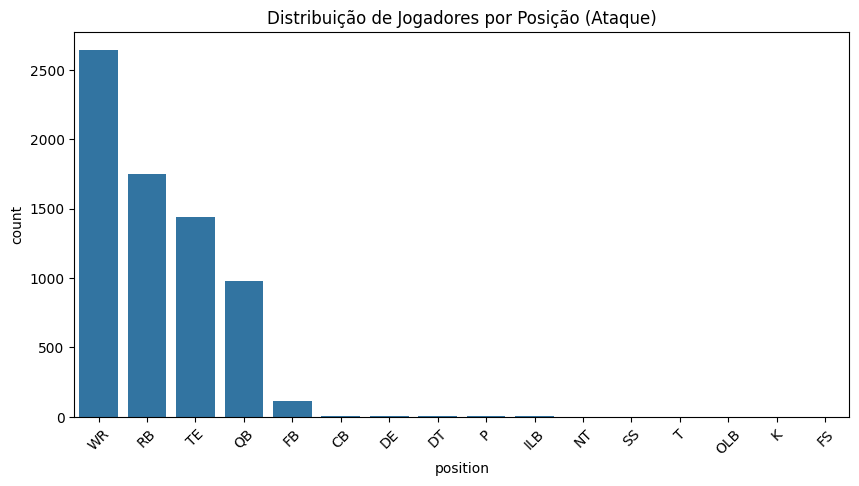

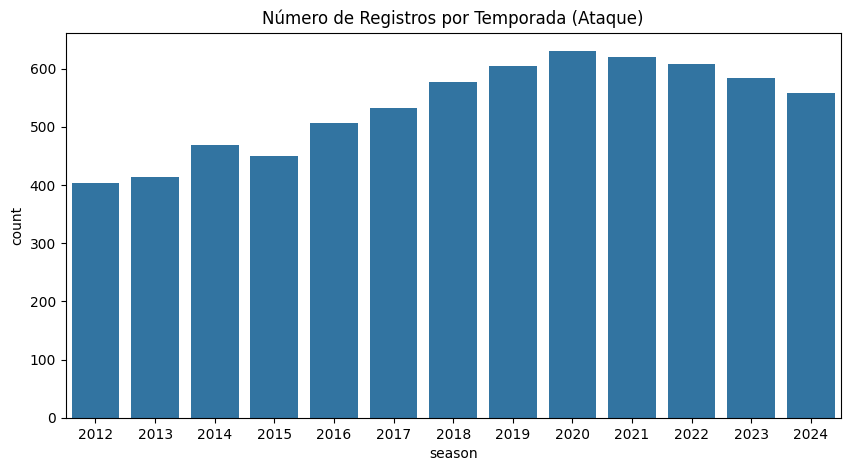

In [165]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='position', order=df_ataque_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Ataque)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='season')
plt.title('Número de Registros por Temporada (Ataque)')
plt.show()


In [169]:
# Estatísticas do ataque
df_ataque_limpo.describe()[['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr']]

,passing_yards,rushing_yards,receiving_yards,total_touchdown,fantasy_points_ppr
count,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000
mean,234.644953,102.130860,221.098504,3.616192,78.678392
std,842.062334,239.783109,306.600714,6.347103,89.907939
min,-7.000000,-31.000000,-15.000000,0.000000,-4.720000
25%,0.000000,0.000000,11.000000,0.000000,11.200000
50%,0.000000,2.000000,85.000000,1.000000,41.400000
75%,0.000000,61.000000,310.000000,4.000000,119.700000
max,5477.000000,2027.000000,1964.000000,56.000000,513.980000


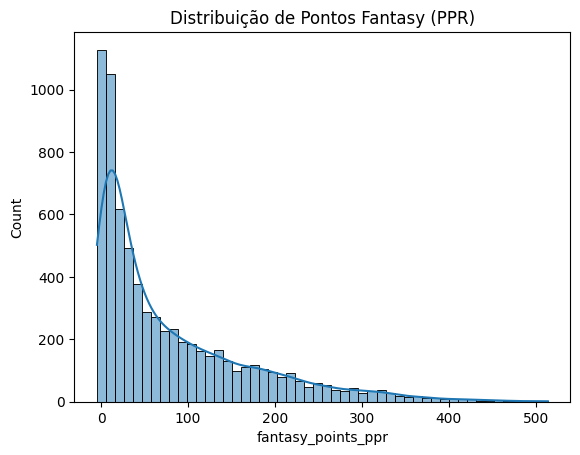

In [170]:
# Distribuição de Potnos do Fantasy
sns.histplot(df_ataque_limpo['fantasy_points_ppr'], bins=50, kde=True)
plt.title('Distribuição de Pontos Fantasy (PPR)')
plt.show()


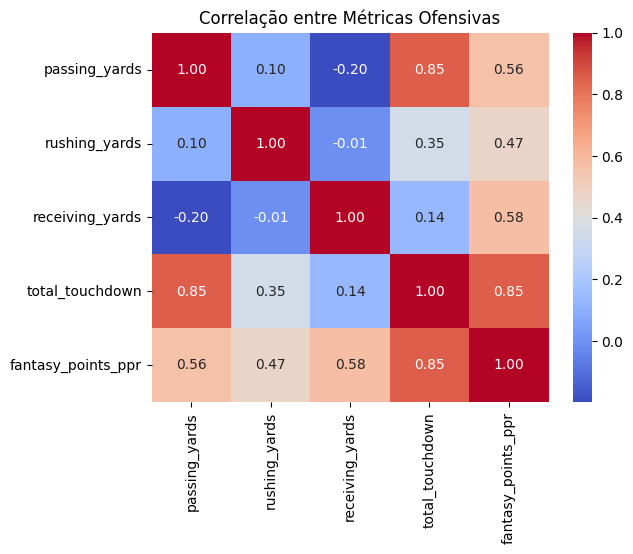

In [171]:
# Correlação entre variáveis
corr_cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr']
sns.heatmap(df_ataque_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Ofensivas')
plt.show()


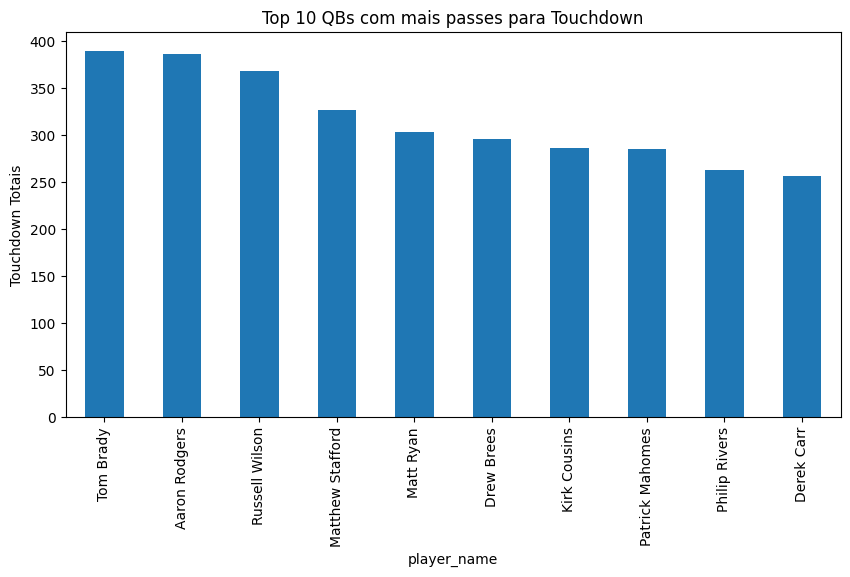

In [193]:
# Top QBs com mais passes para touchdown
qbs= df_ataque_limpo[df_ataque_limpo['position'] == 'QB']
top_qbs_touch = qbs.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch.plot(kind='bar', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown')
plt.ylabel('Touchdown Totais')
plt.show()


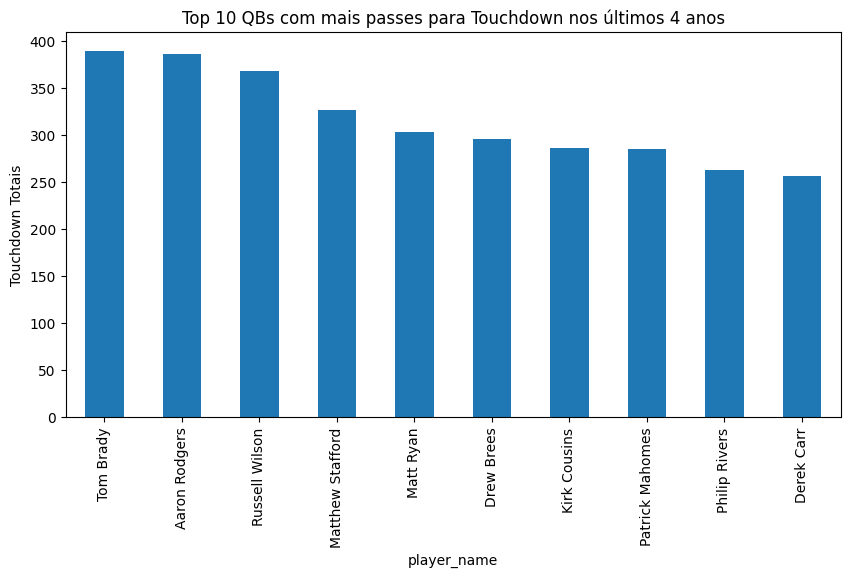

In [194]:
# Top QBs com mais passes para touchdown nos últimos 4 anos
qbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'QB') & (df_ataque_limpo['season'] >= 2020)]
top_qbs_touch = qbs.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch.plot(kind='bar', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown nos últimos 4 anos')
plt.ylabel('Touchdown Totais')
plt.show()

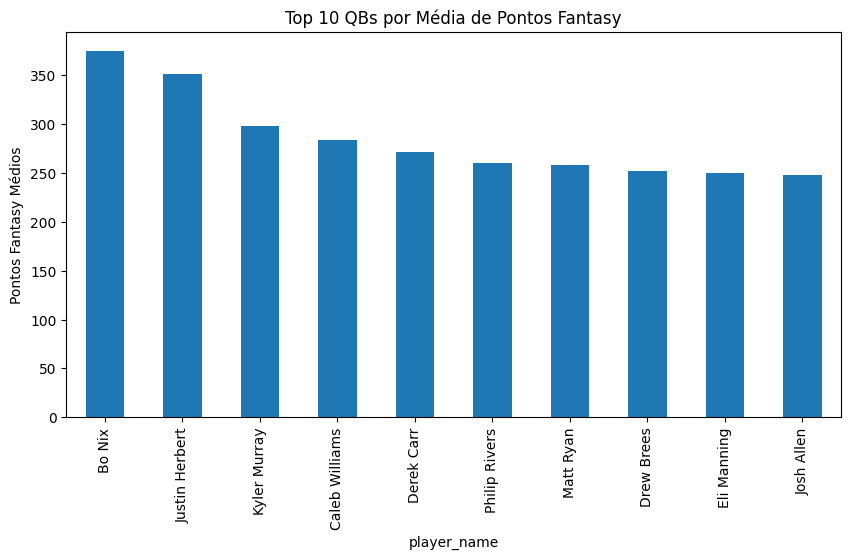

In [183]:
# Top QBs em média de pontos fantasy
top_qbs_fantasy = qbs.groupby('player_name')['fantasy_points_ppr'].mean().nlargest(10)
top_qbs_fantasy.plot(kind='bar', figsize=(10,5), title='Top 10 QBs por Média de Pontos Fantasy')
plt.ylabel('Pontos Fantasy Médios')
plt.show()


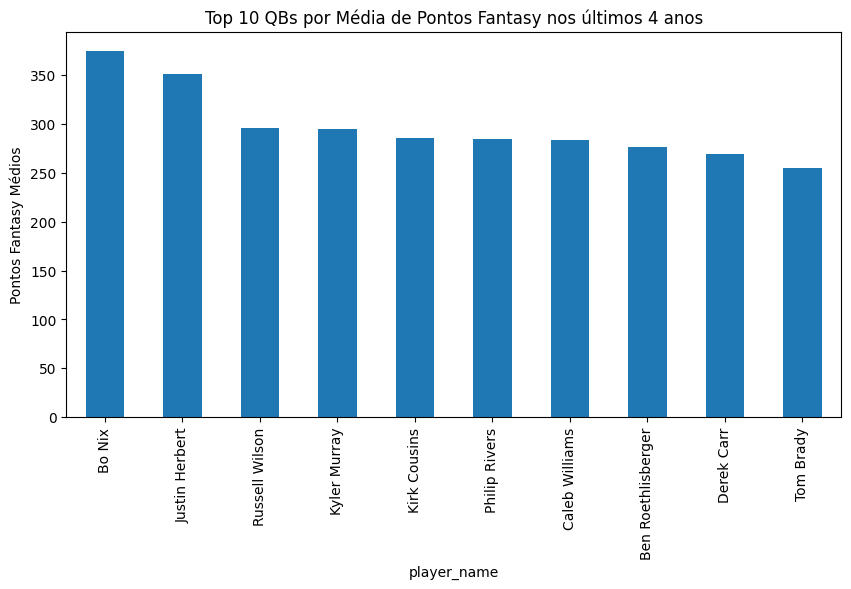

In [196]:
# Top QBs em média de pontos fantasy nos últimos quatros anos
top_qbs_fantasy = qbs_recentes.groupby('player_name')['fantasy_points_ppr'].mean().nlargest(10)
top_qbs_fantasy.plot(kind='bar', figsize=(10,5), title='Top 10 QBs por Média de Pontos Fantasy nos últimos 4 anos')
plt.ylabel('Pontos Fantasy Médios')
plt.show()

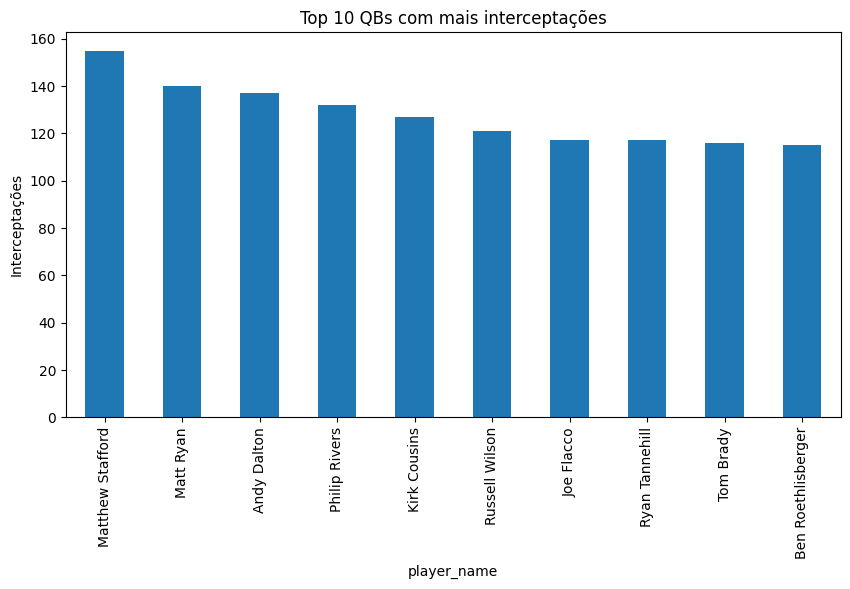

In [186]:
# Top QBs com mais interceptações
top_qbs_int = qbs.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='bar', figsize=(10,5), title='Top 10 QBs com mais interceptações')
plt.ylabel('Interceptações')
plt.show()

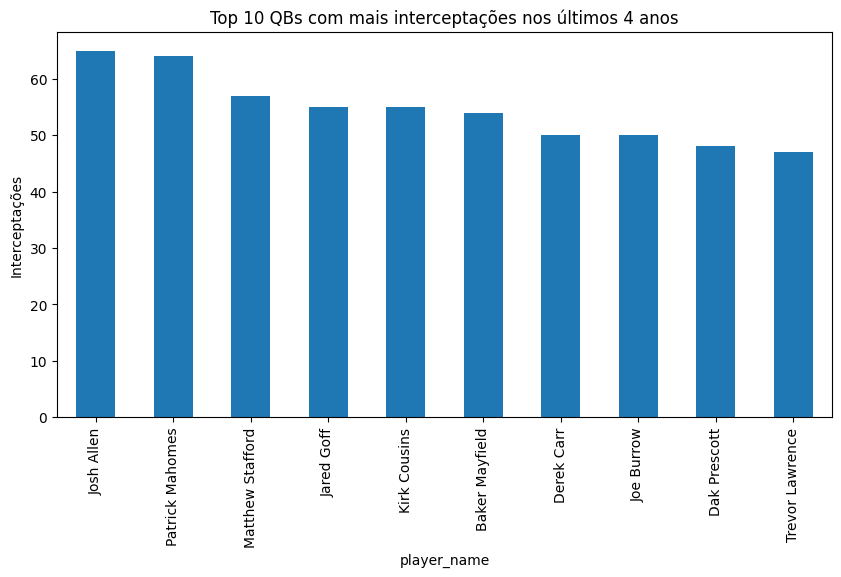

In [197]:
# Top QBs com mais interceptações nos últimos 4 anos
top_qbs_int = qbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='bar', figsize=(10,5), title='Top 10 QBs com mais interceptações nos últimos 4 anos')
plt.ylabel('Interceptações')
plt.show()

###**Defesa**